In [171]:
%matplotlib inline
from datetime import datetime
from datetime import timedelta
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set(font_scale=1.5)

In [288]:
state_codes = {'AK':'Alaska', 'AL':'Alabama', 'AR':'Arkansas', 'AS':'American Samoa', 'AZ':'Arizona', 'CA':'California', 'CO':'Colorado', 
               'CT':'Connecticut', 'DC':'District of Columbia', 'DE':'Delaware', 'FL':'Florida', 'GA':'Georgia', 'GU':'Guam', 'HI':'Hawaii', 
               'IA':'Iowa', 'ID':'Idaho', 'IL':'Illinois', 'IN':'Indiana', 'KS':'Kansas', 'KY':'Kentucky', 'LA':'Louisiana', 'MA':'Massachusetts', 
               'MD':'Maryland', 'ME':'Maine', 'MI':'Michigan', 'MN':'Minnesota', 'MO':'Missouri', 'MP':'Northern Mariana Islands', 
               'MS':'Mississippi', 'MT':'Montana', 'NA':'National', 'NC':'NorthCarolina', 'ND':'NorthDakota', 'NE':'Nebraska', 'NH':'NewHampshire', 
               'NJ':'NewJersey', 'NM':'NewMexico', 'NV':'Nevada', 'NY':'NewYork', 'OH':'Ohio', 'OK':'Oklahoma', 'OR':'Oregon', 'PA':'Pennsylvania', 
               'PR':'PuertoRico', 'RI':'RhodeIsland', 'SC':'SouthCarolina', 'SD':'SouthDakota', 'TN':'Tennessee', 'TX':'Texas', 'UT':'Utah', 
               'VA':'Virginia', 'VI':'Virgin Islands', 'VT':'Vermont', 'WA':'Washington', 'WI':'Wisconsin', 'WV':'WestVirginia', 'WY':'Wyoming'}

def get_state_counts(normalize=True):
    # Used to get hospitalization counts
    import io
    import requests
    response = requests.get('http://covidtracking.com/api/states/daily.csv')
    data = io.StringIO(response.content.decode('utf-8'))
    df = pd.read_csv(data)
    df['state'] = [state_codes[x] for x in df['state']]
    df = df.join(states_pop, on='state', how='inner')
    cols = ['positive', 'negative', 'pending', 'hospitalized', 'death', 'total']
    if normalize:
        df[cols] = df[cols].fillna(0).div(df['Population'], axis=0)
    df['date'] = [datetime.strptime(str(x), '%Y%m%d') for x in df['date']]
    df = df.set_index(['state', 'date'])
    return df

state = get_state_counts(normalize=False)
hospitalized = state['hospitalized'].unstack('state').iloc[-1]
hospitalized = hospitalized[hospitalized.notnull()]
positive = state['positive'].unstack('state').iloc[-1].loc[hospitalized.index]
print("Hospitalizations per confirmed case = %.3g" % (hospitalized.sum() / positive.sum()))

Hospitalizations per confirmed case = 0.146


In [431]:
def get_data():
    response = requests.get('https://coronadatascraper.com/timeseries.csv')
    data = io.StringIO(response.content.decode('utf-8'))
    df = pd.read_csv(data)
    df = df.select_dtypes(include=['float64']).fillna(0).join(df.select_dtypes(include=['object']).fillna(''))
    df['region'] = df.apply(lambda x: ', '.join(x[['city', 'county', 'state', 'country']]).strip(', ').replace(' ,',''), axis=1)
    df['date'] = df['date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    df = df.set_index(['region', 'date'])
    df = df[['cases', 'deaths', 'recovered', 'active', 'tested']].div(df['population'], axis=0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # Ignore log(0) error
        df = np.log10(df)
    df._last = df.loc['USA'].index[-1]
    return df

def extrapolate(df, regions):
    last = df.index[-1]
    f = 0.5  # fraction of population susceptible
    T = 10  # days contagious
    r0 = 2.5
    k = r0/T
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # Ignore log(0) error
        for region in regions:
            c = np.log(f/(10**df.loc[last, region]) - 1)/f
            for t in range(1, 101):
                day = last + timedelta(0, t*3600*24, 0)
                x = f*(1/(1+np.exp(f*(c-k*t))))
                df.loc[day, region] = np.log10(x) if extrapolate else None
    return df

def make_plot(df, # The data
              kind, # Column name
              label, # What to call it
              start='2/28/20', # First date to show
              order=0, # Order of derivative
              regions=['ESP', 'FRA', 'ITA', 'USA',
                       'AZ, USA', 'NY, USA', 'CA, USA', 'ME, USA', 'Maricopa County, AZ, USA'], # Regions to show
              ylim=(-7,0) # Log10 y-axis limits
             ):
    last = df._last
    df = df[kind].unstack('region')
    df = extrapolate(df, regions)
    for i in range(order):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")  # Ignore log(0) error
            df = np.log10((10**df).diff(axis=0))
    first = datetime.strptime(start, '%m/%d/%y')
    colors = ['r', 'g', 'b', 'k', 'c', 'orange', 'gold', 'blue', 'brown', 'purple']
    ax = df.loc[first:last, regions].plot(figsize=(30, 10), linestyle='-', marker='o', color=colors[:len(regions)])
    df.loc[last:, regions].plot(ax=ax, linestyle='--', legend=False, color=colors[:len(regions)])
    tick_locs = df.index[df.index >= first]
    plt.xticks(tick_locs, [datetime.strftime(x, '%m/%d') for x in tick_locs], rotation=75);
    log_units = np.linspace(-6, 0, 7)
    plt.yticks(log_units, ['1 in %.0f' % (10.0**-x) for x in log_units]);
    plt.xlabel('Date')
    plt.ylabel('Number of residents per %s' % label);
    plt.ylim(-7, 0);

In [413]:
df = get_data()

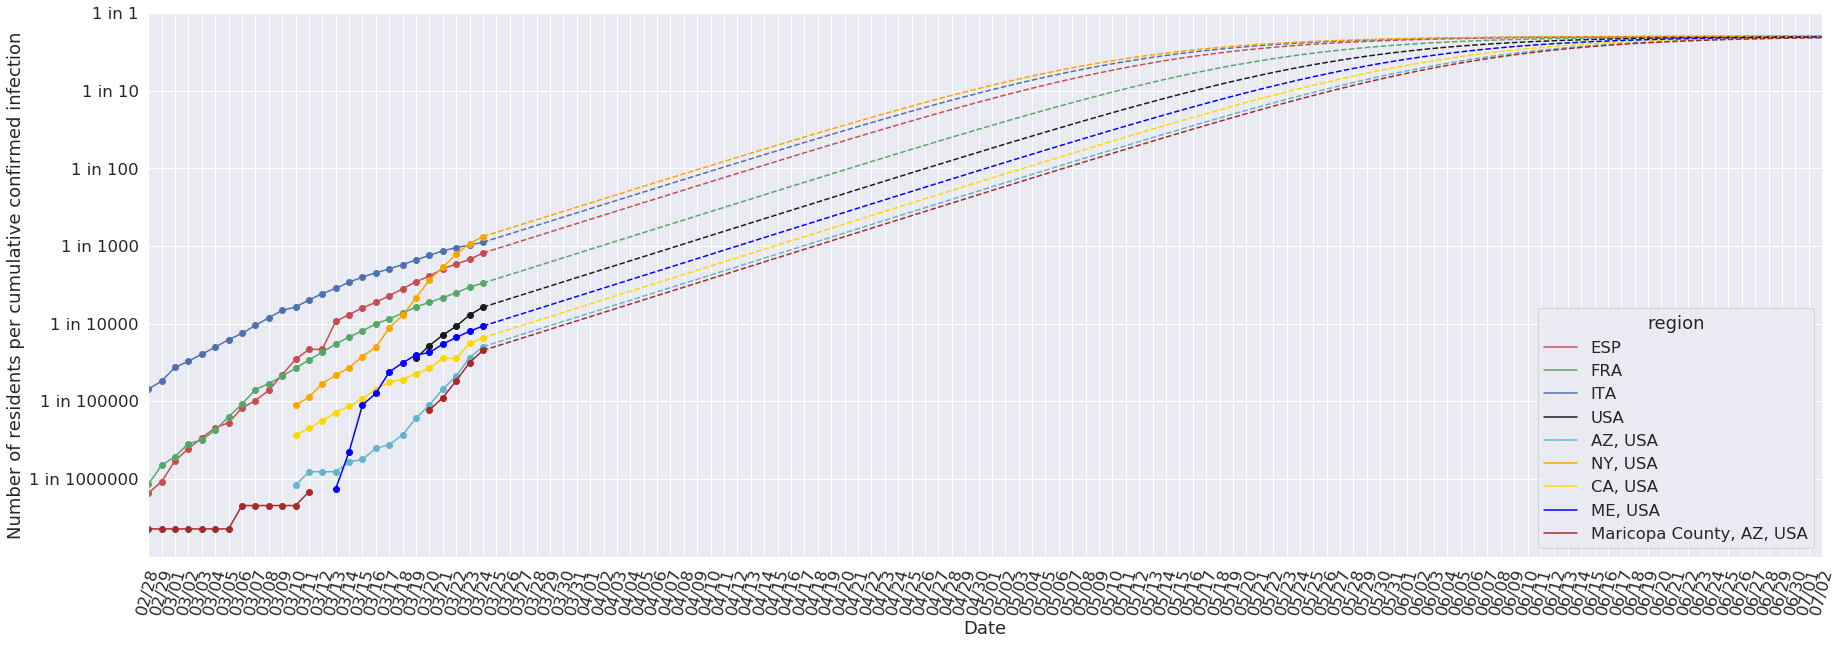

In [432]:
make_plot(df, 'cases', 'cumulative confirmed infection')

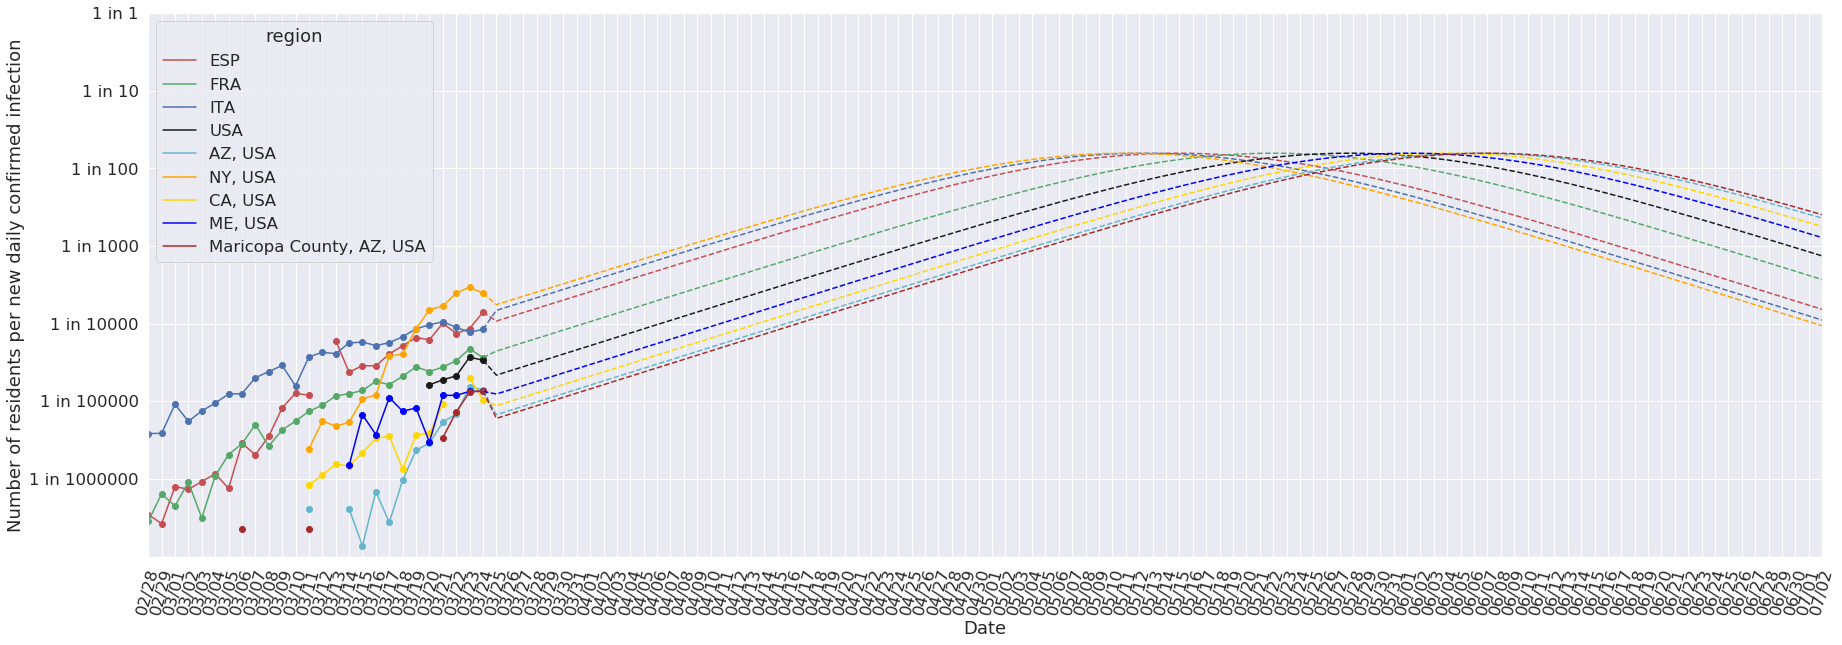

In [433]:
make_plot(df, 'cases', 'new daily confirmed infection', order=1)

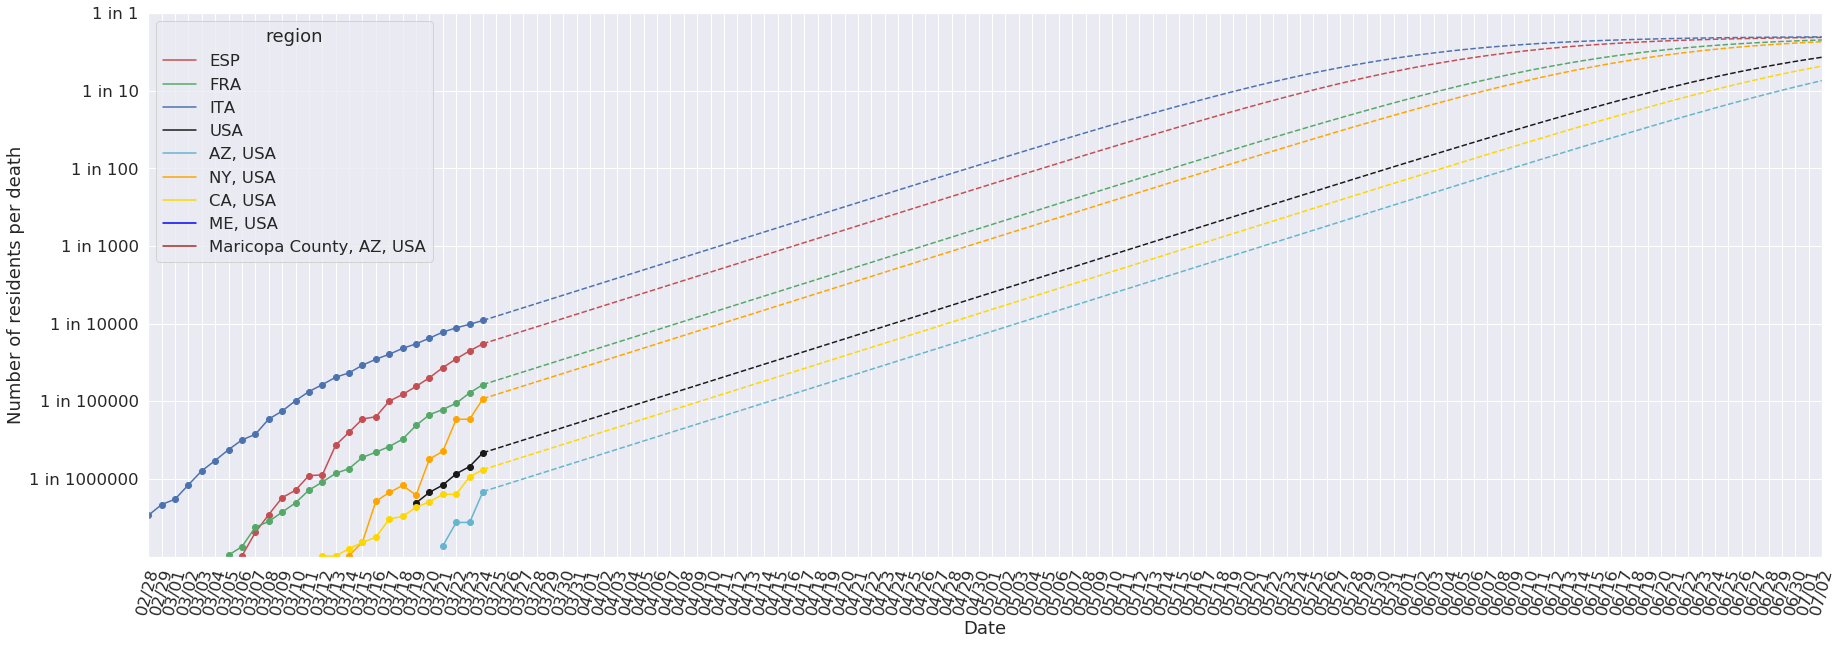

In [434]:
make_plot(df, 'deaths', 'death', ylim=(-9,0))

(-8, 0)

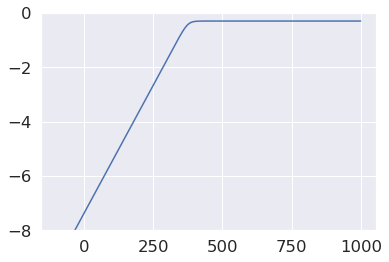

In [31]:
import numpy as np
f = 0.5
r = 0.2
c = 75
t = np.arange(-100, 1000, 1)
def xt(t, r, f, c):
    x = f*(1/(1+np.exp(f*(c-r*t))))
    return x
logx = np.log(f) - np.log10(1 + np.exp(f*(c-r*t)))
log10x = np.log10(np.exp(logx))
#plt.plot(t, 10**log10x);
#plt.ylim(0, f+0.01)
plt.plot(t, log10x);
plt.ylim(-8, 0)

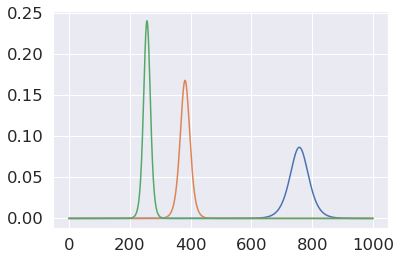

In [43]:
t = np.arange(0, 1000, 1)
T = 14
for r in [0.1, 0.2, 0.3]:
    y = xt(t, r) - xt(t-T, r)
    plt.plot(t, y)

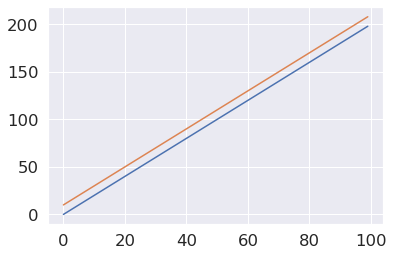

In [92]:
a = 10
r = 2
t = np.arange(0, 100, 1)
plt.plot(t, t*r)
plt.plot(t, a + t*r);

In [231]:
from neo.core import AnalogSignal
import quantities as pq
raw = np.zeros(10000)
cooked = AnalogSignal(raw, units=pq.V, sampling_rate=10*pq.kHz)

In [238]:
import sys
import inspect

def get_size(obj, seen=None):
    """Recursively finds size of objects in bytes"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if hasattr(obj, '__dict__'):
        for cls in obj.__class__.__mro__:
            if '__dict__' in cls.__dict__:
                d = cls.__dict__['__dict__']
                if inspect.isgetsetdescriptor(d) or inspect.ismemberdescriptor(d):
                    size += get_size(obj.__dict__, seen)
                break
    if isinstance(obj, dict):
        size += sum((get_size(v, seen) for v in obj.values()))
        size += sum((get_size(k, seen) for k in obj.keys()))
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        try:
            size += sum((get_size(i, seen) for i in obj))
        except:
            pass
        
    if hasattr(obj, '__slots__'): # can have __slots__ with __dict__
        size += sum(get_size(getattr(obj, s), seen) for s in obj.__slots__ if hasattr(obj, s))
        
    return size

get_size(raw), get_size(cooked)

(309120, 19947)

In [237]:
sys.getsizeof(raw), sys.getsizeof(cooked.__dict__)

(80096, 160)